# Web Scraping the 2019 Michelin Restaurant Guide

The Michelin Guide is a book that is published by the tire company, Michelin. This guide details restaurants that offer the highest quality cuisine. The Michelin Guide has a rating of 1-star, 2-star, and 3-star. More stars generally means higher the quality. 

The star ratings are defined as detailed by the International Culinary Center:

- One star: The restaurant is considered very good in its category but is limited in some way. This restaurant has a quality menu and prepares cuisine to a consistently high standard, but it may lack a unique element that would bring people back over and over again.
- Two stars: The restaurant has excellent cuisine delivered in a unique way. This restaurant has something exceptional to offer and is worth a detour to visit while traveling.
- Three stars: The restaurant has exceptional cuisine and is worth a special trip just to visit. Rather than being a stop on the way to a destination, this restaurant is the destination. This restaurant serves distinct dishes that are executed to perfection.

Also, there are two other ratings within the Michelin Guide. 'Bib Gourmand' and 'The Plate MICHELIN'.

- Bib Gourmand: Exceptionally good food at moderate prices
- The Plate MICHELIN: Fresh ingredients, carefully prepared: a good meal

In [1]:
# Imports
from bs4 import BeautifulSoup
import time
from IPython.core.display import clear_output
import random
from requests import get
from warnings import warn
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Setting base url
url = 'https://guide.michelin.com/en/restaurants/page/1'

## Understanding the HTML Structure

Before we can start web scraping, we have to understand the HTML Structure so we know how we can extract the data we want.

Using BeautifulSoup, we can easily parse the data we want.

Below, we can see classes that contain the data we want:

- Restaurants are contained in class 'col-md-6 col-lg-6 col-xl-3'
- Distinctions (Ratings) are contained in class 'fa-michelin'
- Restaurant names are contained in class 'card__menu-content--title'
- Both Cuisines and Prices are contained in 'card__menu-footer--price'

Using these classes, we can scrape each page to get the data.

In [2]:
page = get(url)
soup = BeautifulSoup(page.content, 'html.parser')
results = soup.find(class_ = 'col-lg-12 search-results__column')
restaurants = results.find_all(class_ = 'col-md-6 col-lg-6 col-xl-3')
print(restaurants[0])

<div class="col-md-6 col-lg-6 col-xl-3">
<div class="card__menu js-match-height js-map" data-index="0" data-lat="37.35131" data-lng="-121.85845">
<div class="card__menu-image">
<a class="image-wrapper js-image-bg" data-position-x="50" data-position-y="50" href="/en/restaurants?region=california&amp;city=south-san-francisco">
<img alt="" class="img-fluid" src="https://d3h1lg3ksw6i6b.cloudfront.net/guide/xlarge/498398_1.jpg"/>
</a>
</div>
<div class="card__menu-content js-match-height-content">
<div class="card__menu-content--rating d-flex">
<i class="fa-michelin">‹</i>
<span>
                MICHELIN Guide 2019
            </span>
</div>
<h5 class="card__menu-content--title last">
<a href="/en/california/south-san-francisco/restaurant/adega">
                Adega
            </a>
</h5>
</div>
<div class="card__menu-footer d-flex">
<div class="card__menu-footer--location flex-fill">
<div class="icon fal fa-map-marker-alt"></div>
            South San Francisco - 95116
        </div>
<di

## Preparing the Web Scraper

Now that we know what we want to scrape. We can start the prepare the web scraper.

We know that there is 132 pages in the Michelin Guide by manually visitng the last results page. So we created a string list that we use to loop over alongside the based url.

Since we are making 132 requests to the Michelin Guide. We want to make sure that we won't make too many requests to their server too quickly. To help with this, we will use sleep the loop in random interval between 8 seconds and 15 seconds.

We also want to monitor the loop as it is going through each page. This scraper might take awhile to complete so we will monitor which number of requests we are on the speed of the request.

In [3]:
pages = [str(i) for i in range(1,133)]

In [4]:
distinctions = []
names = []
locations = []
prices = []

start_time = time.time()
requests = 0

for page in pages:
    # Make a get request
    response = get('https://guide.michelin.com/en/restaurants/page/' + page)
    
    # Pausing loop
    time.sleep(random.randint(8,15))
    
    # Monitor the requests
    requests += 1
    elapsed_time = time.time() - start_time
    print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
    clear_output(wait = True)
    
    # Warning for non-200 status codes
    if response.status_code != 200:
            warn('Request: {}; Status code: {}'.format(requests, response.status_code))
            
    # Break the loop if the number of requests is greater than expected
    if requests > 132:
        warn('Number of requests was greater than expected.')
        break
    
    # Parse the html content
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Select the results container
    restaurants = soup.find_all('div', class_ = 'col-md-6 col-lg-6 col-xl-3')
    
    for restaurant in restaurants:
        # Scraping distinction
        distinction = restaurant.find(class_ = 'fa-michelin').get_text(strip = True)
        distinctions.append(distinction)
        
        # Scraping name
        name = restaurant.find(class_ = 'card__menu-content--title').get_text(strip = True)
        names.append(name)
        
        # Scraping location
        location = restaurant.find('div', class_ = 'card__menu-footer--location flex-fill').get_text(strip = True)
        locations.append(location)
        
        # Scraping price
        price = restaurant.find(class_ = 'card__menu-footer--price').get_text(strip = True)
        prices.append(price)

Request:132; Frequency: 0.0820846422452584 requests/s


In [5]:
# Creating a DataFrame
michelin_guide = pd.DataFrame(
    {
        'distinction': distinctions,
        'name': names,
        'location': locations,
        'price': prices
    })

## Inspecting the Scraped Data

Looking at the data it looks like the head and tails of the dataframe match the same restaurants on the website. We have scraped 2,628 restaurants. This number matches the number of restaunras on the website as well.

We can see that we have some cleaning to do. We will move onto that next.

In [6]:
# First 5 rows
michelin_guide.head()

,distinction,name,location,price
0,‹,Adega,South San Francisco - 95116,Portuguese · \n \n ...
1,‹,Back A Yard,South San Francisco - 95113,Caribbean · \n \n ...
2,=,Luna Mexican Kitchen,South San Francisco - 95101,Mexican · \n \n ...
3,‹,Walia,South San Francisco - 95128,Ethiopian · \n \n ...
4,‹,Din Tai Fung,South San Francisco - 95050,Chinese · \n \n ...


In [7]:
# Last 5 rows
michelin_guide.tail()

,distinction,name,location,price
2623,‹,Osia,Singapore,Australian · \n \n ...
2624,‹,Peony Jade (Keppel),Singapore,Cantonese · \n \n ...
2625,‹,Feng Shui Inn,Singapore,Cantonese · \n \n ...
2626,‹,Syun,Singapore,Japanese contemporary · \n \n ...
2627,‹,Ivy's Hainanese Herbal Mutton Soup,Singapore,Street Food · \n \n ...


In [8]:
# Saving DataFrame to csv
michelin_guide.to_csv('michelin_guide.csv')

In [9]:
# Reading csv file
data = pd.read_csv('michelin_guide.csv')

## Cleaning the Data

### Cleaning the Distinction Column

From looking at the HTML structure, we know that the each distinction is indicated by certain characters.

The distinctions is indicated as:
- < : The Plate MICHELIN
- = : Bib Gourmand
- m : 1 star MICHELIN
- n : 2 star MICHELIN
- o : 3 star MICHELIN

Let's get a value count to make sure we converted the the right amount of distinctions.

In [10]:
# Counting values
data['distinction'].value_counts()

‹    1567
=     618
m     338
n      76
o      29
Name: distinction, dtype: int64

In [11]:
# Creating copy of DataFrame
cleaned_distinction = data.copy()

# Replacing characters with distinction titles
cleaned_distinction = cleaned_distinction.replace(['‹', '=', 'm', 'n', 'o'],
                    ['The Plate', 'Bib Gourmand', '1-Star', '2-Star', '3-Star'])

In [12]:
# Counting clean values
cleaned_distinction['distinction'].value_counts()

The Plate       1567
Bib Gourmand     618
1-Star           338
2-Star            76
3-Star            29
Name: distinction, dtype: int64

### Cleaning the Name Column

This column should be fairly easy to clean as there shouldn't be any mispellings in the names. However we do want to see if there are any null values.

Based on the results below there are no null values.

In [13]:
# Creating copy of DataFrame
cleaned_name = cleaned_distinction.copy()

# Checking for duplicate values
n_null = cleaned_name['name'].isna().sum()
n_null

0

### Cleaning the Location Name

In [14]:
# Creating copy of DataFrame
cleaned_location = cleaned_name.copy()
# Location value count
cleaned_location['location'].value_counts()

Singapore                      239
Hong Kong                      227
Bangkok                        171
Taipei - 110                   161
Macau                           70
Phuket                          37
New York - 10014                35
New York - 10003                35
Wien - 1010                     33
New York                        28
New York - 10013                28
New York - 10012                26
New York - 10019                25
Chicago - 60647                 23
Washington, D.C. - 20001        22
New York - 10002                21
Chicago - 60607                 21
Praha - 110 00                  20
Chicago - 60654                 19
Washington, D.C. - 20009        18
New York - 10009                18
Salzburg - 5020                 18
Chicago - 60611                 17
New York - 10011                17
San Francisco - 94601           16
San Francisco - 94110           15
Washington, D.C. - 20003        14
San Francisco - 94102           14
Aarhus - 8000       

In [15]:
# Splitting string into seperate columns
location_split = cleaned_location['location'].str.split('-', expand = True)

# Replacing location values
cleaned_location['location'] = location_split[0]

In [16]:
# Location value count
cleaned_location['location'].value_counts()

New York                   512
San Francisco              272
Singapore                  239
Hong Kong                  227
Chicago                    192
Bangkok                    171
Taipei                     161
Washington, D.C.           126
Macau                       70
Wien                        67
København                   66
Stockholm                   48
Phuket                      37
Oslo                        35
South San Francisco         31
Praha                       31
Helsingfors / Helsinki      30
New York                    28
Warszawa                    27
Budapest                    26
Kraków                      25
Göteborg                    19
Salzburg                    19
Athína                      18
Aarhus                      15
Zagreb                      15
Malmö                       14
Dubrovnik                   11
Reykjavík                    8
Chicago                      7
                          ... 
Varaždin                     1
Skodsbor

In [17]:
cleaned_location.head()

,Unnamed: 0,distinction,name,location,price
0,0,The Plate,Adega,South San Francisco,Portuguese · \n \n ...
1,1,The Plate,Back A Yard,South San Francisco,Caribbean · \n \n ...
2,2,Bib Gourmand,Luna Mexican Kitchen,South San Francisco,Mexican · \n \n ...
3,3,The Plate,Walia,South San Francisco,Ethiopian · \n \n ...
4,4,The Plate,Din Tai Fung,South San Francisco,Chinese · \n \n ...


### Cleaning the Price Column

In [18]:
# Creating a copy of the dataframe
cleaned_price = cleaned_location.copy()
# First 5 rows
cleaned_price['price'].head()

0    Portuguese · \n                \n             ...
1    Caribbean · \n                \n              ...
2    Mexican · \n                \n                ...
3    Ethiopian · \n                \n              ...
4    Chinese · \n                \n                ...
Name: price, dtype: object

In [19]:
# Stripping the strings into seperate series
price_split = cleaned_price['price'].str.split('\n', expand = True)
# Printing the series data
price_split

,0,1,2
0,Portuguese ·,,$$$
1,Caribbean ·,,$
2,Mexican ·,,$$
3,Ethiopian ·,,$
4,Chinese ·,,$$
5,Korean ·,,$$
6,Japanese ·,,$$$$
7,Vietnamese ·,,$
8,Vietnamese ·,,$$
9,Middle Eastern ·,,$$


In [20]:
# Saving the cuisine into a new series
cleaned_price['cuisine'] = price_split[0]
# Saving the pricing into a new series
cleaned_price['pricing'] = price_split[2]

In [21]:
# Dropping the original price series
cleaned_price.drop(columns = ['price'], inplace = True)

In [22]:
# First 5 rows
cleaned_price.head()

,Unnamed: 0,distinction,name,location,cuisine,pricing
0,0,The Plate,Adega,South San Francisco,Portuguese ·,$$$
1,1,The Plate,Back A Yard,South San Francisco,Caribbean ·,$
2,2,Bib Gourmand,Luna Mexican Kitchen,South San Francisco,Mexican ·,$$
3,3,The Plate,Walia,South San Francisco,Ethiopian ·,$
4,4,The Plate,Din Tai Fung,South San Francisco,Chinese ·,$$


### Cleaning the Cuisine Column

In [23]:
# Creating a copy of the dataframe
cleaned_cuisine = cleaned_price.copy()

In [27]:
# Cleaning extra characters
cleaned_cuisine['cuisine'] = cleaned_cuisine['cuisine'].str.replace('·', '')
# Cleaning white spaces
cleaned_cuisine['cuisine'] = cleaned_cuisine['cuisine'].str.strip()
# Printing dataframe
cleaned_cuisine

,Unnamed: 0,distinction,name,location,cuisine,pricing
0,0,The Plate,Adega,South San Francisco,Portuguese,$$$
1,1,The Plate,Back A Yard,South San Francisco,Caribbean,$
2,2,Bib Gourmand,Luna Mexican Kitchen,South San Francisco,Mexican,$$
3,3,The Plate,Walia,South San Francisco,Ethiopian,$
4,4,The Plate,Din Tai Fung,South San Francisco,Chinese,$$
5,5,The Plate,Jang Su Jang,South San Francisco,Korean,$$
6,6,The Plate,Sawa Sushi,South San Francisco,Japanese,$$$$
7,7,The Plate,Thiên Long,South San Francisco,Vietnamese,$
8,8,The Plate,Lau Hai San,South San Francisco,Vietnamese,$$
9,9,The Plate,DishDash,South San Francisco,Middle Eastern,$$


### Cleaning the Pricing Column

In [41]:
# Creating a copy of the dataframe
cleaned_pricing = cleaned_cuisine.copy()

In [42]:
# Count of pricing distinctions
cleaned_pricing['pricing'].value_counts()

                    $$       979
                    $        728
                    $$$      441
                    $$$$     338
                    $$$$$    142
Name: pricing, dtype: int64

In [43]:
# Cleaning white spaces
cleaned_pricing['pricing'] = cleaned_pricing['pricing'].str.strip()

In [46]:
# Changing dollar signs to numerical values
cleaned_pricing['pricing'] = cleaned_pricing['pricing'].replace(['$', '$$', '$$$', '$$$$', '$$$$$'], ['1', '2', '3', '4', '5'])

In [47]:
# Count of pricing distinctions
cleaned_pricing['pricing'].value_counts()

2    979
1    728
3    441
4    338
5    142
Name: pricing, dtype: int64

In [49]:
# Renaming series
cleaned_pricing.rename(columns = {'pricing': 'pricing (by $)'})

,Unnamed: 0,distinction,name,location,cuisine,pricing (by $)
0,0,The Plate,Adega,South San Francisco,Portuguese,3
1,1,The Plate,Back A Yard,South San Francisco,Caribbean,1
2,2,Bib Gourmand,Luna Mexican Kitchen,South San Francisco,Mexican,2
3,3,The Plate,Walia,South San Francisco,Ethiopian,1
4,4,The Plate,Din Tai Fung,South San Francisco,Chinese,2
5,5,The Plate,Jang Su Jang,South San Francisco,Korean,2
6,6,The Plate,Sawa Sushi,South San Francisco,Japanese,4
7,7,The Plate,Thiên Long,South San Francisco,Vietnamese,1
8,8,The Plate,Lau Hai San,South San Francisco,Vietnamese,2
9,9,The Plate,DishDash,South San Francisco,Middle Eastern,2


In [48]:
# First 5 rows
cleaned_pricing.head()

,Unnamed: 0,distinction,name,location,cuisine,pricing
0,0,The Plate,Adega,South San Francisco,Portuguese,3
1,1,The Plate,Back A Yard,South San Francisco,Caribbean,1
2,2,Bib Gourmand,Luna Mexican Kitchen,South San Francisco,Mexican,2
3,3,The Plate,Walia,South San Francisco,Ethiopian,1
4,4,The Plate,Din Tai Fung,South San Francisco,Chinese,2


### Saving the Cleaned Data to csv

For now I will save what I have cleaned so far as I will come back to this project at a later time. I am not done with the cleaning process so I will have to read in the csv and continue cleaning from there.

In [50]:
# Saving dataframe to csv
cleaned_pricing.to_csv('cleaned_michelin_guide.csv')

### Reading in the Cleaned csv and Additional Cleaning

In [2]:
# Reading the csv file
data = pd.read_csv('cleaned_michelin_guide.csv').copy()

In [3]:
# Dropping extra series
data.drop(columns = ['Unnamed: 0'], inplace = True)

In [4]:
# Dropping extra series
data.drop(columns = ['Unnamed: 0.1'], inplace = True)

In [5]:
# Cleaning white spaces
data['location'] = data['location'].str.strip()

In [6]:
# Cleaning white spaces
data['cuisine'] = data['cuisine'].str.strip()

## Basic Exploratory Data Analysis

#### Description of Distinction:
- One star: The restaurant is considered very good in its category but is limited in some way. This restaurant has a quality menu and prepares cuisine to a consistently high standard, but it may lack a unique element that would bring people back over and over again.
- Two stars: The restaurant has excellent cuisine delivered in a unique way. This restaurant has something exceptional to offer and is worth a detour to visit while traveling.
- Three stars: The restaurant has exceptional cuisine and is worth a special trip just to visit. Rather than being a stop on the way to a destination, this restaurant is the destination. This restaurant serves distinct dishes that are executed to perfection.
- Bib Gourmand: Exceptionally good food at moderate prices
- The Plate MICHELIN: Fresh ingredients, carefully prepared: a good meal

#### Description of Pricing:
- 1: Under 25 USD
- 2: 25 - 50 USD
- 3: 50 - 75 USD
- 4: Over 75 USD
- 5: Over 100 USD

In [7]:
pandas_profiling.ProfileReport(data)

Number of variables,5
Number of observations,2628
Total Missing (%),0.0%
Total size in memory,102.7 KiB
Average record size in memory,40.0 B
Numeric,1
Categorical,4
Boolean,0
Date,0
Text (Unique),0
Rejected,0


### Which Cuisine Appeared the Most Overall?

- Street Food appears the most with over 250 counts. However I suspect that we won't see this cusine once we start looking at only the Michelin Star restaurants

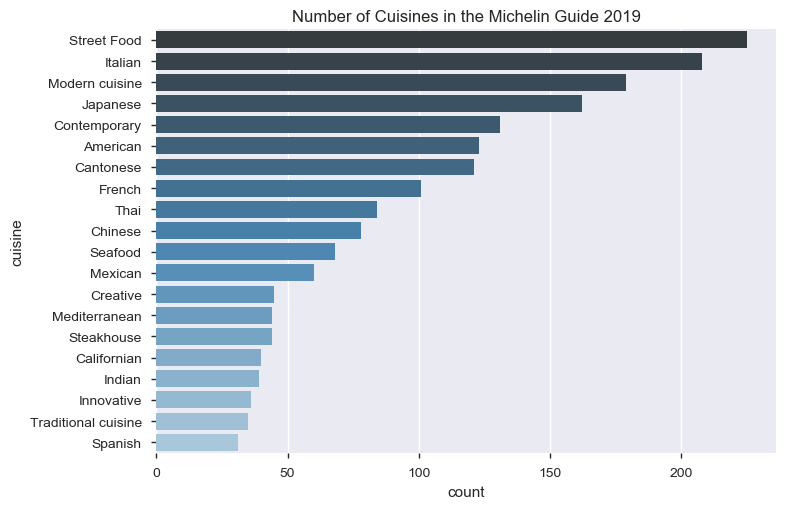

In [8]:
# Countplot of cuisines
ax = sns.countplot(y = 'cuisine', data = data, order = data['cuisine'].value_counts()[:20].index, palette = 'Blues_d').set_title('Number of Cuisines in the Michelin Guide 2019')

### Which Location Appeared the Most Overall?

- New York appears more often by a large margin with over 550 restaurants.
- San Francisco appeared the second most often with over 250 restaurants.

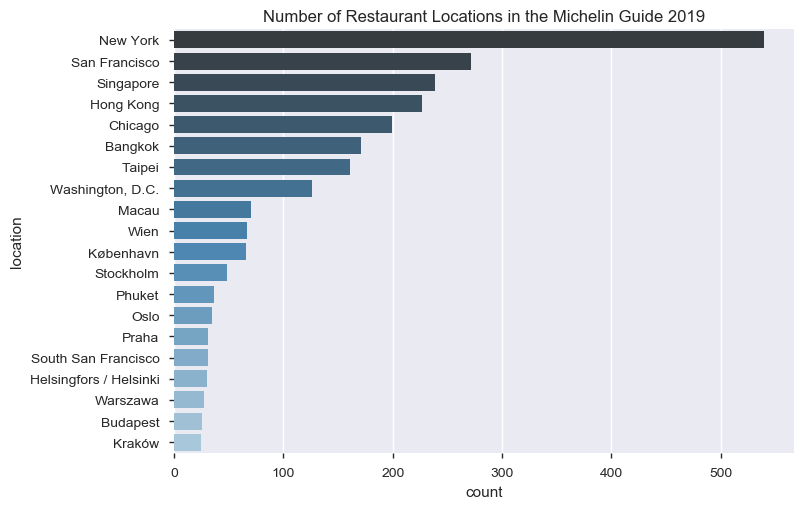

In [9]:
# Countplot of locations
ax = sns.countplot(y = 'location', data = data, order = data['location'].value_counts()[:20].index, palette = 'Blues_d').set_title('Number of Restaurant Locations in the Michelin Guide 2019')

### What is the Count of each Distinction?

- The Plate has almost 1600 restaurants in the Michelin Guide. This makes sense though since the requirements for The Plate vs Michelin Stars are lower.
- Conversly, 3-Star restaurants have very few.

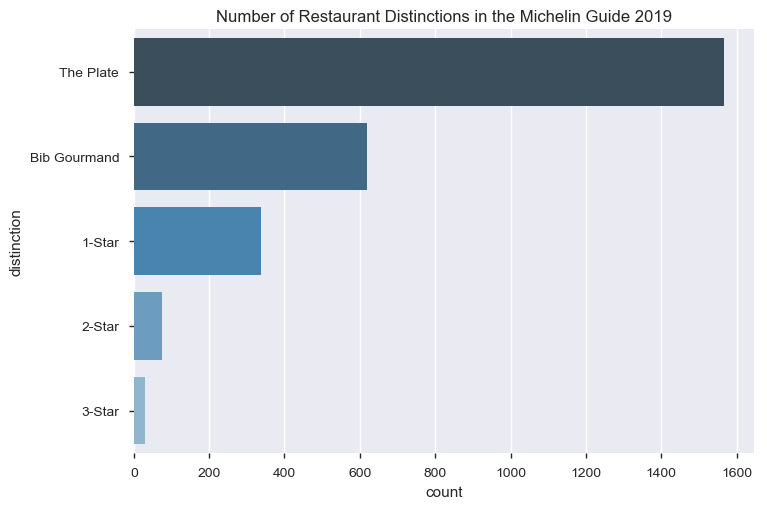

In [11]:
# Countplot of distinctions
ax = sns.countplot(y = 'distinction', data = data, order = data['distinction'].value_counts().index, palette = 'Blues_d').set_title('Number of Restaurant Distinctions in the Michelin Guide 2019')

### Which Cuisine has the Most 1-Star Michelin?

- The top two cuisines for 1-Star Michelin restaurants are 'Modern Cuisine' and 'Contemporary'. Since Michelin stars are moving towards more fine dining. This would make sense why 'Modern Cuisine' and 'Contemporary are more common in the 1-Star distinction.
- The next two cuisines for 1-Star Michelin restaurants are 'Cantonese' and 'Japanese'. There are probably more traditional cuisine but elevated to be more fine dining.

In [12]:
# Filter data by 1-Star Michelin
star_1 = data[data['distinction'] == '1-Star']

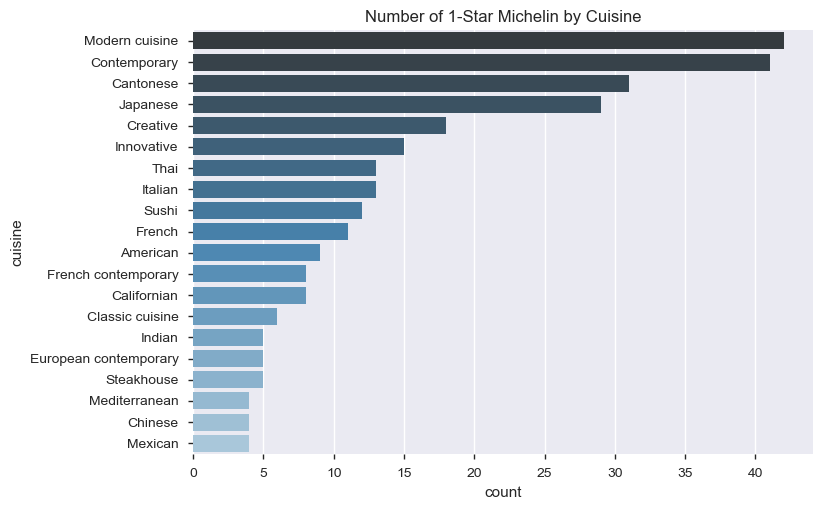

In [12]:
# Countplot of 1-Star Michelin
ax = sns.countplot(y = 'cuisine', data = star_1, order = star_1['cuisine'].value_counts()[:20].index, palette = 'Blues_d').set_title('Number of 1-Star Michelin by Cuisine')

### Which Cuisine has the Most 2-Star Michelin?

- The top two cuisines for 2-Star restaurants are 'Contemporary' and 'Creative'. Just like 1-star Michelin restaurants these makes sense as the most common cuisines for fine dining.
- Comparing between 1-star Michelin restaurants, both 'Cantonese' and 'Japanese' has droped from their spot and replaced by 'French Contemporary' and 'Innovate' both of which would are more fine dining cuisines.

In [13]:
# Filter data by 2-Star Michelin
star_2 = data[data['distinction'] == '2-Star']

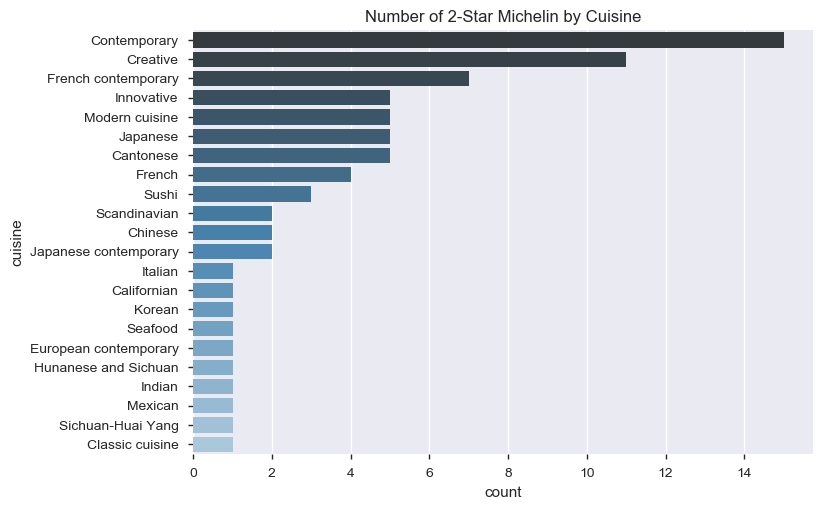

In [14]:
# Countplot of 2-Star Michelin
ax = sns.countplot(y = 'cuisine', data = star_2, order = star_2['cuisine'].value_counts().index, palette = 'Blues_d').set_title('Number of 2-Star Michelin by Cuisine')

### Which Cuisine has the Most 3-Star Michelin?

- 'Contemporary' is the most common 3-Star Michelin Cuisine with 10 restaurants.
- Suprisingly, 'Cantonese' has the second most common 3-Star Michelin. I would have suspected 'Creative' or 'Innovative' to be take the spot.

In [15]:
#Filter by 3-Star Michelin
star_3 = data[data['distinction'] == '3-Star']

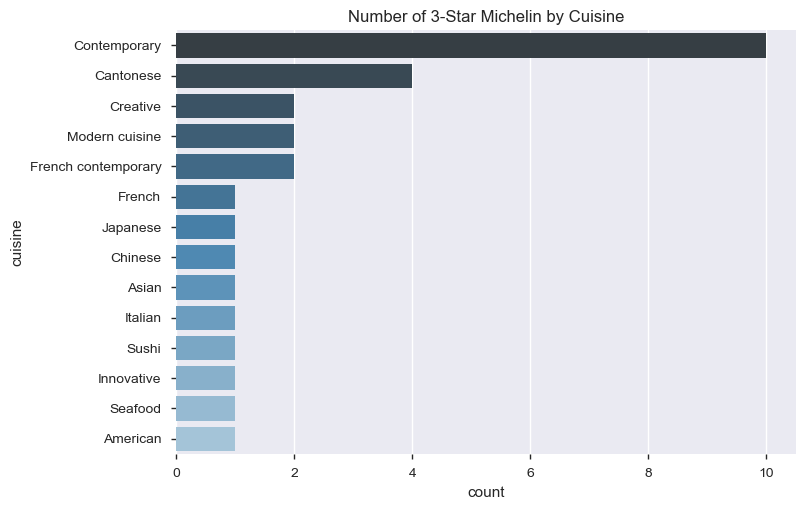

In [16]:
# Countplot of 3-Star Michelin
ax = sns.countplot(y = 'cuisine', data = star_3, order = star_3['cuisine'].value_counts().index, palette = 'Blues_d').set_title('Number of 3-Star Michelin by Cuisine')

### Which Location has the Most 1-Star Michelin?

- New York has the most 1-Star Michelin restaurants
- Hong Kong has the second most 1-Star Michelin restaurants
- San Francisco has the the third most 3-Star Michelin restaurants

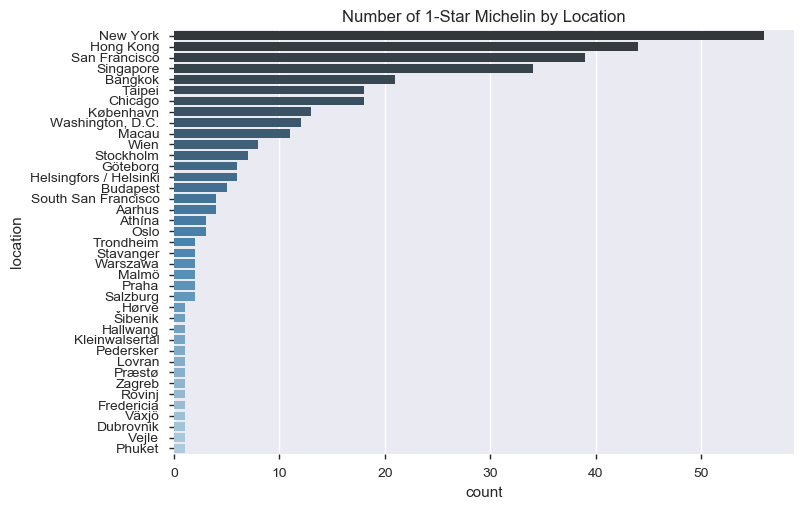

In [17]:
# Countplot of 1-Star Michelin by location
ax = sns.countplot(y = 'location', data = star_1, order = star_1['location'].value_counts().index, palette = 'Blues_d').set_title('Number of 1-Star Michelin by Location')

### Which  Location has the Most 2-Star Michelin?

Just like the 1-Star Michelin restaurants.

- New York has the most 1-Star Michelin restaurants
- Hong Kong has the second most 1-Star Michelin restaurants
- San Francisco has the the third most 3-Star Michelin restaurants

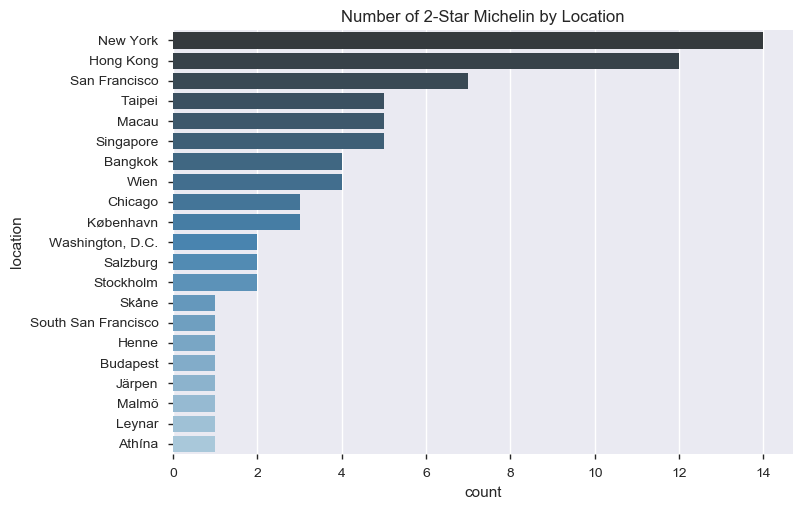

In [18]:
# Countplot of 2-Star Michelin by Location
ax = sns.countplot(y = 'location', data = star_2, order = star_2['location'].value_counts().index, palette = 'Blues_d').set_title('Number of 2-Star Michelin by Location')

### Which Location has the Most 3-Star Michelin?

- Hong Kong has the most 3-Star Michelin restaurants
- New York dropped to having the third most 3-Star Michelin restaurants

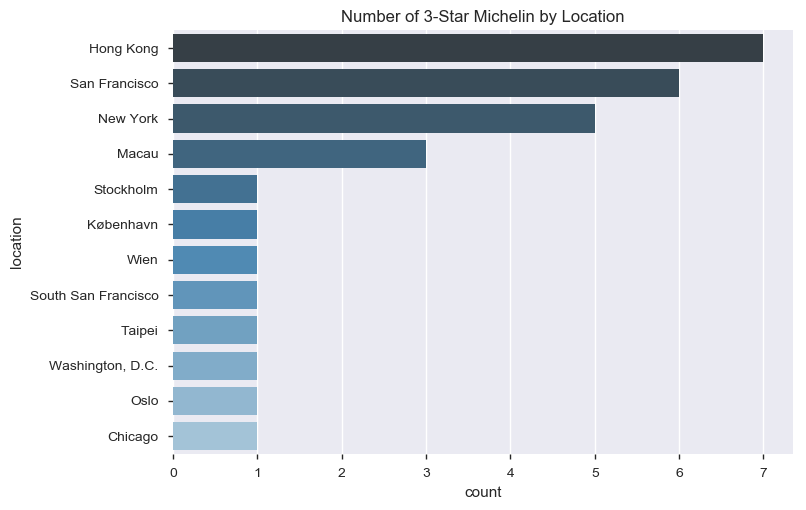

In [19]:
# Countplot of 3-Star Michelin by location
ax = sns.countplot(y = 'location', data = star_3, order = star_3['location'].value_counts().index, palette = 'Blues_d').set_title('Number of 3-Star Michelin by Location')

### Which Location has the Most Michelin Stars Overall?

- Since this is a sum of the previous three plots. New York, Hong Kong, and San Francisco still hold the top three spots.

In [20]:
# Filter data by all Michelin Stars
michelin_stars = data[(data['distinction'] != 'The Plate') & (data['distinction'] != 'Bib Gourmand')]

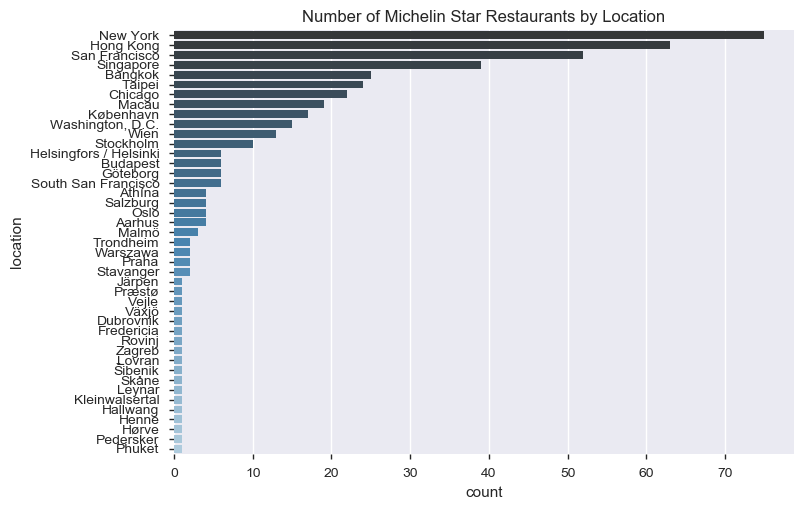

In [21]:
# Countplot of all Michelin Stars by location
ax = sns.countplot(y = 'location', data = michelin_stars, order = michelin_stars['location'].value_counts().index, palette = 'Blues_d').set_title('Number of Michelin Star Restaurants by Location')

### What Type of Cuisines Appear in the Cities with the Most Michelin Stars?

In [22]:
# Filter New York Michelin Stars
ny_michelin_stars = michelin_stars[michelin_stars['location'] == 'New York']

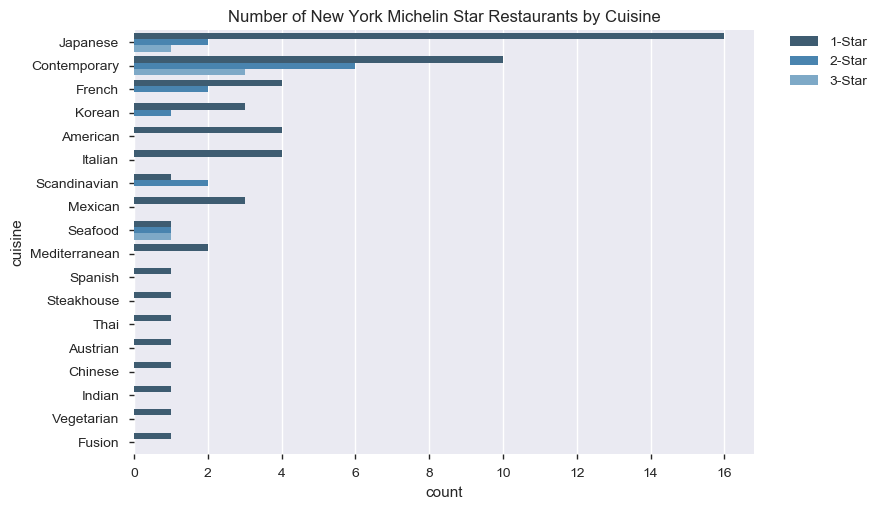

In [23]:
# Countplot of New York Michelin Stars by cuisine
ax = sns.countplot(y = 'cuisine', data = ny_michelin_stars, order = ny_michelin_stars['cuisine'].value_counts().index, palette = 'Blues_d', hue  = 'distinction').set_title('Number of New York Michelin Star Restaurants by Cuisine')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

- Japanese Cuisine has the most overall Michelin Star restaurants in New York with sixteen 1-Star, two 2-Star, and one 3-Star. A total of 19 restaurants.
- Contemporary is tied with Japanese with the most overall Michelin Star restauraunts with ten 1-Star, six 2-Star, and three 3-Star. A total of 19 restauarants.

In [24]:
# Filter Hong Kong Michelin Stars
hk_michelin_stars = michelin_stars[michelin_stars['location'] == 'Hong Kong']

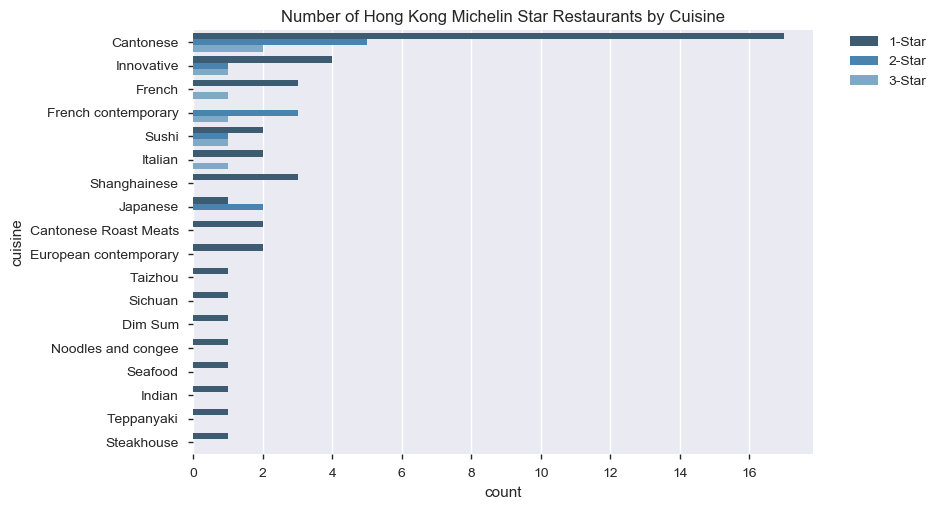

In [25]:
# Countplot of Hong Kong Michelin Stars by cuisine
ax = sns.countplot(y = 'cuisine', data = hk_michelin_stars, order = hk_michelin_stars['cuisine'].value_counts().index, palette = 'Blues_d', hue = 'distinction').set_title('Number of Hong Kong Michelin Star Restaurants by Cuisine')
# Move legend out of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

- Cantonese has the most Michelin Star restaurants with seventeen 1-Star, five 2-Star, and two 3-Star. A total of 24 restaurants.
- Innovative has the second most Michelin Star restaurants with four 1-Star, one 2-Star, and one 3-Star. A total of 6 restaurants.

In [26]:
# Filter San Francisco Michelin Stars
sf_michelin_stars = michelin_stars[michelin_stars['location'] == 'San Francisco']

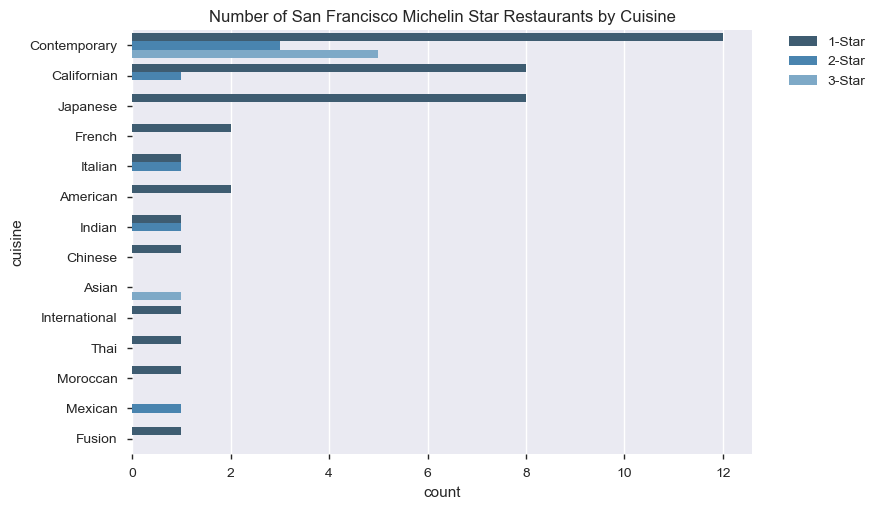

In [27]:
# Countplot of San Francisco Michelin Stars by cuisine
ax = sns.countplot(y = 'cuisine', data = sf_michelin_stars, order = sf_michelin_stars['cuisine'].value_counts().index, palette = 'Blues_d', hue = 'distinction').set_title('Number of San Francisco Michelin Star Restaurants by Cuisine')
# Move legend out of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

- Contemporary has the most Michelin Star restaurants with twelve 1-Star, three 2-Star, and five 3-Star. A total of 20 restaurants.
- Californian has the second most Michelin Star restaurants with eight 1-Star, one 2-Star, and zero 3-Star. A total of of 9 restaurants.
- The only other cuisine with 3-Star is Asian cuisine.

### What Pricing do Michelin Star Restaurants Fall Under?

- Most 1-Star restaurants pricing start from 50 USD to over 75 USD.
- Most 2-Star restaurants pricing are over 75 USD.
- Most 3-Star restaurants pricing are over 75 USD.

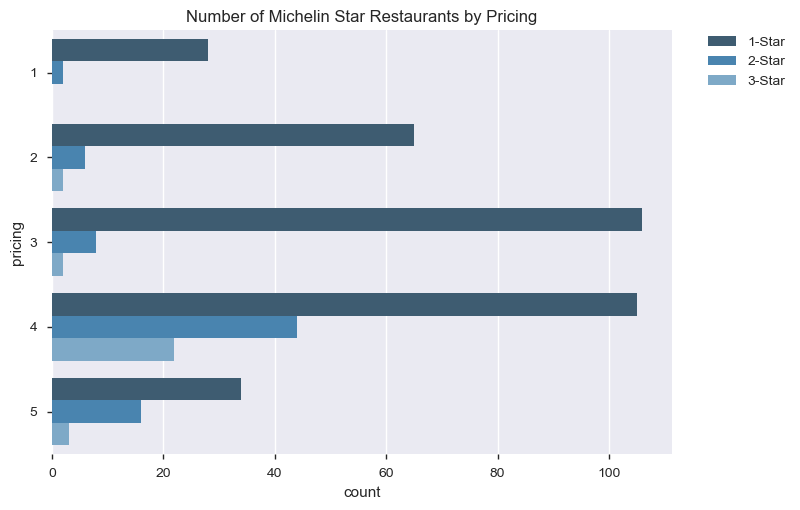

In [28]:
# Countplot of all Michelin Stars by pricing
ax = sns.countplot(y = 'pricing', data = michelin_stars, palette = 'Blues_d', hue = 'distinction').set_title('Number of Michelin Star Restaurants by Pricing')
# Move legend out of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Conclusion

The main goal of this project was to try my hand at web scraping and I figured web scraping the 2019 Michelin Guide would be interesting to look at. We looked at the different types of cuisines, the locations of restaurants, and their pricing structure. If I wanted to go on a Michelin guided restaurant tour, the best place to go is New York. New York having the most Michelin Star restaurants as well as a guide variety of cuisines.

We can continue looking at the Michelin Guide to compile more restaurant data. Since we last ran the web scrapper, around 2,000 more restaurants have been added to the 2019 Michelin Guide. We could add to our data set to see how it changes are current plots.